In [138]:
#Final project: Predicting salary based of regular season and playoff series perforamce for NBA season 2017-2018.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from pylab import *

In [139]:
#Import salary dataset
salary = pd.read_csv("nba_salary1718.csv")
raw_season = pd.read_csv("nba_season_stats1718.csv")
raw_playoffs = pd.read_csv("nba_playoffs_stats1718.csv")

In [140]:
#Data has missing zero values, there are columns that have a divide my zero error
#Delete column 'Rk' as it is not useful to data, just a way for the dataset to be organized
salary = salary.fillna(0)
salary = salary.drop(columns = ['Unnamed: 0'] )
salary = salary.rename(columns = {'season17_18' : 'Salary/Year'})
season = raw_season.fillna(0)
season = season.drop(columns = ['Rk'])
playoffs = raw_playoffs.fillna(0)
playoffs = playoffs.drop(columns = ['Rk'])

In [141]:
salary.head()

,Player,Tm,Salary/Year
0,Stephen Curry,GSW,34682550.0
1,LeBron James,CLE,33285709.0
2,Paul Millsap,DEN,31269231.0
3,Gordon Hayward,BOS,29727900.0
4,Blake Griffin,DET,29512900.0


In [142]:
playoffs.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Alex Abrines\abrinal01,SG,24,OKC,6,0,18.3,1.3,3.3,0.400,...,1.000,0.5,2.2,2.7,0.3,0.8,0.3,0.2,1.8,4.0
1,Steven Adams\adamsst01,C,24,OKC,6,6,33.3,4.5,7.7,0.587,...,0.692,3.2,4.3,7.5,1.5,0.7,0.7,0.7,2.5,10.5
2,Bam Adebayo\adebaba01,C,20,MIA,5,0,15.4,1.4,3.0,0.467,...,0.214,1.8,2.2,4.0,0.0,0.0,0.4,0.4,1.6,3.4
3,LaMarcus Aldridge\aldrila01,C,32,SAS,5,5,35.4,7.4,16.0,0.463,...,0.976,2.6,6.6,9.2,2.4,0.6,0.4,1.8,1.8,23.6
4,Al-Farouq Aminu\aminual01,PF,27,POR,4,4,32.8,6.8,13.0,0.519,...,1.000,3.0,6.0,9.0,1.3,1.0,0.5,1.5,2.0,17.3


In [143]:
#Player names have an extra unique code, remove everything after '\'
season['Player'] = (season['Player']).map(lambda x: x.split("\\")[0])
playoffs['Player'] = (playoffs['Player']).map(lambda x: x.split("\\")[0])

In [144]:
#Merge the data with the salary data wiht the player name and team
#This is will leave out the data for players with team as 'TOT'. Some of the players that played in multiple teams have aggregated of multiple team stats.
merged_season = season.merge(salary, on = ['Player', 'Tm'], how = 'inner')
merged_playoffs = playoffs.merge(salary, on = ['Player', 'Tm'], how = 'inner')


In [145]:
merged_season.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary/Year
0,Alex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,...,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,5725000.0
1,Quincy Acy,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,...,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9,1709538.0
2,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9,22471910.0
3,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9,2490360.0
4,Arron Afflalo,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,...,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4,2328652.0


In [146]:
merged_playoffs.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary/Year
0,Alex Abrines,SG,24,OKC,6,0,18.3,1.3,3.3,0.400,...,0.5,2.2,2.7,0.3,0.8,0.3,0.2,1.8,4.0,5725000.0
1,Steven Adams,C,24,OKC,6,6,33.3,4.5,7.7,0.587,...,3.2,4.3,7.5,1.5,0.7,0.7,0.7,2.5,10.5,22471910.0
2,Bam Adebayo,C,20,MIA,5,0,15.4,1.4,3.0,0.467,...,1.8,2.2,4.0,0.0,0.0,0.4,0.4,1.6,3.4,2490360.0
3,LaMarcus Aldridge,C,32,SAS,5,5,35.4,7.4,16.0,0.463,...,2.6,6.6,9.2,2.4,0.6,0.4,1.8,1.8,23.6,21461010.0
4,Al-Farouq Aminu,PF,27,POR,4,4,32.8,6.8,13.0,0.519,...,3.0,6.0,9.0,1.3,1.0,0.5,1.5,2.0,17.3,7319035.0


In [147]:
#Summary statistics for playoffs
merged_playoffs.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary/Year
count,199.00000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,...,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,1.990000e+02
mean,26.81407,8.336683,4.070352,20.195477,3.172864,6.975879,0.435603,0.831658,2.385930,0.249839,...,0.776382,2.815578,3.588442,1.823116,0.630151,0.401508,1.091960,1.779397,8.568844,8.133832e+06
std,4.41080,5.625718,5.635841,12.158641,2.720696,5.838000,0.198663,0.936711,2.418386,0.210265,...,0.841292,2.360600,2.967095,2.116737,0.574980,0.506072,1.054062,1.059697,7.423321,8.267247e+06
min,19.00000,1.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.190100e+05
25%,23.00000,5.000000,0.000000,9.200000,1.000000,2.000000,0.360000,0.000000,0.150000,0.000000,...,0.200000,1.000000,1.300000,0.400000,0.150000,0.000000,0.350000,1.000000,2.400000,1.578335e+06
50%,26.00000,7.000000,1.000000,20.500000,2.800000,6.000000,0.444000,0.600000,1.900000,0.286000,...,0.500000,2.200000,2.700000,1.200000,0.500000,0.300000,0.800000,1.800000,7.100000,4.328000e+06
75%,30.00000,10.500000,6.000000,31.800000,4.600000,10.000000,0.511000,1.200000,3.700000,0.376500,...,1.000000,4.100000,5.200000,2.400000,1.000000,0.600000,1.500000,2.600000,12.400000,1.335151e+07
max,40.00000,22.000000,22.000000,41.900000,12.500000,26.800000,1.000000,4.300000,10.800000,1.000000,...,3.900000,10.800000,13.400000,12.200000,2.400000,3.500000,5.200000,4.300000,34.000000,3.468255e+07


<BarContainer object of 199 artists>

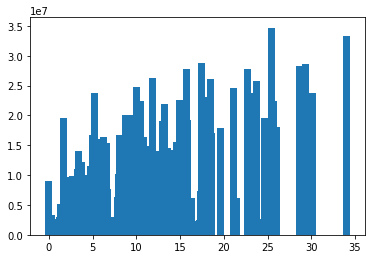

In [148]:
plt.bar(merged_playoffs['PTS'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

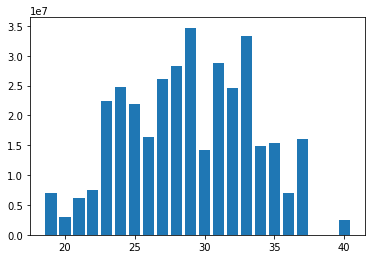

In [149]:
plt.bar(merged_playoffs['Age'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

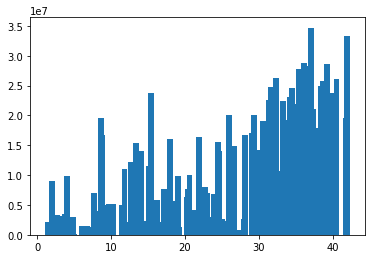

In [150]:
plt.bar(merged_playoffs['MP'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

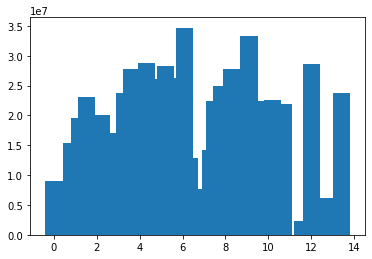

In [151]:
plt.bar( merged_playoffs['TRB'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

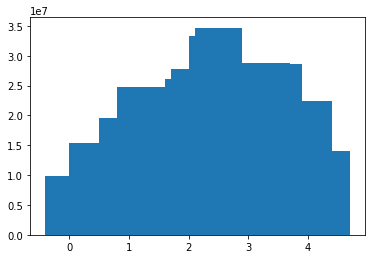

In [152]:
plt.bar(merged_playoffs['PF'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

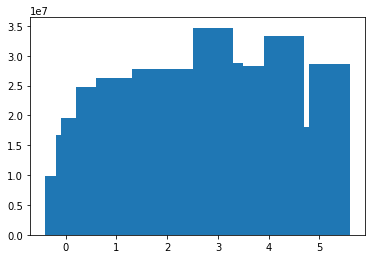

In [153]:
plt.bar(merged_playoffs['TOV'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

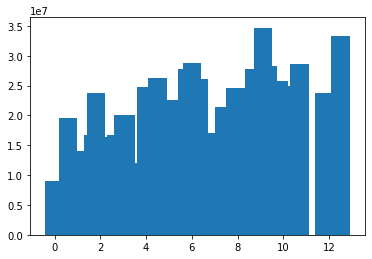

In [154]:
plt.bar(merged_playoffs['FG'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

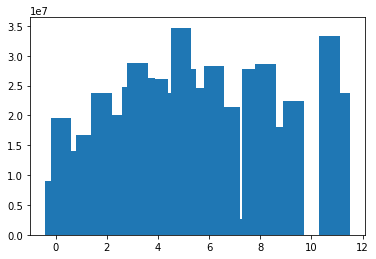

In [155]:
plt.bar(merged_playoffs['2P'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

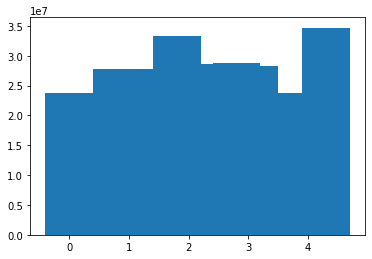

In [156]:
plt.bar(merged_playoffs['3P'], merged_playoffs['Salary/Year'])

<BarContainer object of 199 artists>

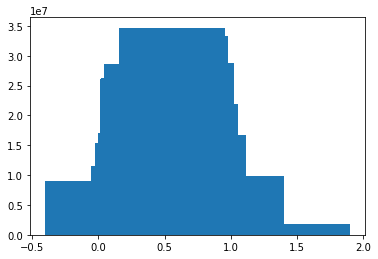

In [157]:
plt.bar(merged_playoffs['eFG%'], merged_playoffs['Salary/Year'])

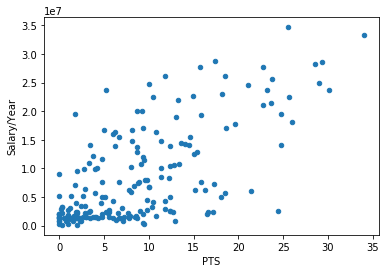

In [158]:
x = merged_playoffs.plot.scatter('PTS', 'Salary/Year')

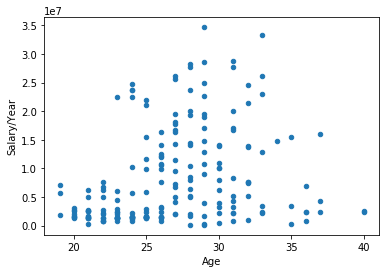

In [159]:
x = merged_playoffs.plot.scatter('Age', 'Salary/Year')

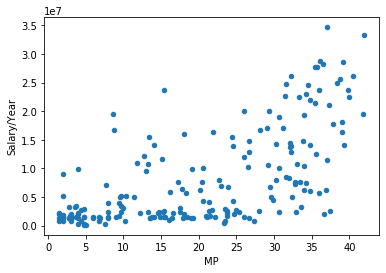

In [160]:
x = merged_playoffs.plot.scatter('MP', 'Salary/Year')

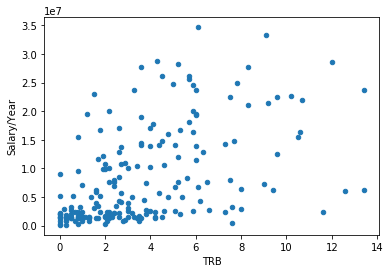

In [161]:
x = merged_playoffs.plot.scatter('TRB', 'Salary/Year')

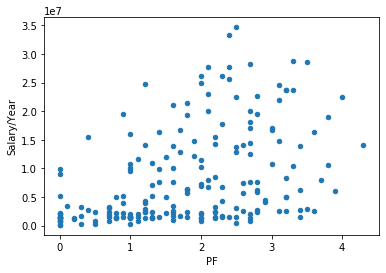

In [162]:
x = merged_playoffs.plot.scatter('PF', 'Salary/Year')

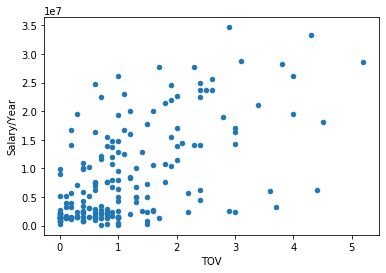

In [163]:
x = merged_playoffs.plot.scatter('TOV', 'Salary/Year')

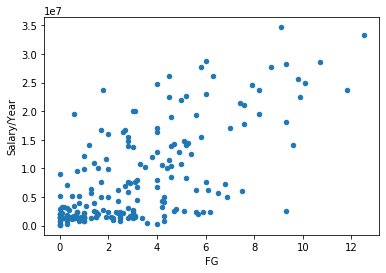

In [164]:
x = merged_playoffs.plot.scatter('FG', 'Salary/Year')

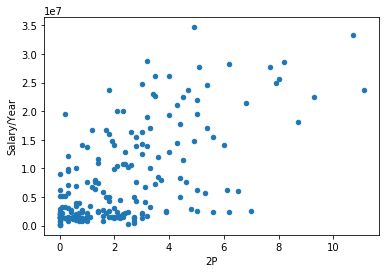

In [165]:
x = merged_playoffs.plot.scatter('2P', 'Salary/Year')

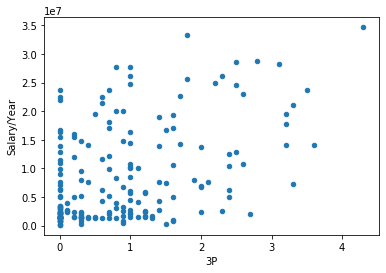

In [166]:
x = merged_playoffs.plot.scatter('3P', 'Salary/Year')

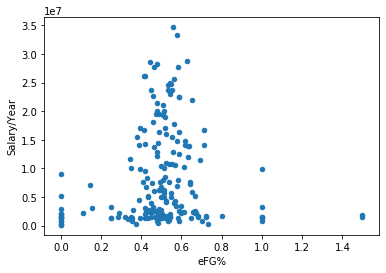

In [167]:
x = merged_playoffs.plot.scatter('eFG%', 'Salary/Year')

In [168]:
#LASSO regression model to determine the best possible predictor values
model = linear_model.Lasso(alpha = 100000, normalize = True)
predicted = model.fit(X = merged_playoffs.iloc[:,[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]], y = merged_playoffs['Salary/Year'])
print(predicted.coef_)
print(predicted.intercept_)
model.score(X = merged_playoffs.iloc[:,[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]], y = merged_playoffs['Salary/Year']) # print R squared

[ 95297.7273435       0.         146611.80777681  18815.85642457
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.         301427.2237047
      0.         432717.31056348]
564721.6559159197


0.4818885776169297

In [169]:
#Split the data between predictor and response variables
#predictor variables (Age, G, GS, TOV, PTS)
x_train, x_test, y_train, y_test = train_test_split(merged_playoffs[['Age', 'G', 'GS', 'TOV', 'PTS']], merged_playoffs['Salary/Year'], test_size = 0.25, random_state = 0)

In [170]:
#Standardize the training ans test set for playoffs with LASSO variables
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [171]:
#Build a linear regression model for playoffs with LASSO variables
model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled, y = y_train)
predicted = fitted_model.predict( x_test_scaled )
corr_coef = np.corrcoef(predicted, y_test)[1, 0]
R_squared = np.corrcoef(predicted, y_test)[1, 0] ** 2
print(fitted_model.coef_)
print("corr_coef: ", corr_coef)
print("R_sqaured: ", R_squared)
print("Adj R_sqaured: ", 1- ((1-R_squared)*(len(y_test)-1)/(len(y_test)-5-1)))

[ 2106643.10160898 -1508361.7378368   2512795.80263967   747059.42629035
  3729348.82845521]
corr_coef:  0.71702091908023
R_sqaured:  0.5141189983986578
Adj R_sqaured:  0.4589052482166871


In [172]:
#Split the data between predictor and response variables
#predictor variables (Age, MP, PTS)
x_train, x_test, y_train, y_test = train_test_split(merged_playoffs[['Age','MP','PTS']], merged_playoffs['Salary/Year'], test_size = 0.25, random_state = 0)

In [173]:
#Standardize the training and test set for playoffs with our obervations from graphs
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [174]:
#Build a linear regression model for playoffs with our obervations from graphs
model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled, y = y_train)
predicted = fitted_model.predict( x_test_scaled )
corr_coef = np.corrcoef(predicted, y_test)[1, 0]
R_squared = np.corrcoef(predicted, y_test)[1, 0] ** 2
print(fitted_model.coef_)
print("corr_coef: ", corr_coef)
print("R_sqaured: ", R_squared)
print("Adj R_sqaured: ", 1- ((1-R_squared)*(len(y_test)-1)/(len(y_test)-3-1)))

[1777384.13850016 1476867.06335749 4223275.03327855]
corr_coef:  0.6993463912046773
R_sqaured:  0.4890853748910056
Adj R_sqaured:  0.4557648558621581


In [175]:
#Function to classify each scoring type of a player based on our point cutoffs
def setPlayerType(x):
    if (x <= 10.0):
        return 1
    elif (x > 10.0) and (x < 20.0) :
        return 2
    elif(x >= 20.0):
        return 3
        

In [176]:
merged_playoffs['sType'] = merged_playoffs['PTS'].map(lambda x: setPlayerType(x))

In [177]:
merged_playoffs.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary/Year,sType
0,Alex Abrines,SG,24,OKC,6,0,18.3,1.3,3.3,0.400,...,2.2,2.7,0.3,0.8,0.3,0.2,1.8,4.0,5725000.0,1
1,Steven Adams,C,24,OKC,6,6,33.3,4.5,7.7,0.587,...,4.3,7.5,1.5,0.7,0.7,0.7,2.5,10.5,22471910.0,2
2,Bam Adebayo,C,20,MIA,5,0,15.4,1.4,3.0,0.467,...,2.2,4.0,0.0,0.0,0.4,0.4,1.6,3.4,2490360.0,1
3,LaMarcus Aldridge,C,32,SAS,5,5,35.4,7.4,16.0,0.463,...,6.6,9.2,2.4,0.6,0.4,1.8,1.8,23.6,21461010.0,3
4,Al-Farouq Aminu,PF,27,POR,4,4,32.8,6.8,13.0,0.519,...,6.0,9.0,1.3,1.0,0.5,1.5,2.0,17.3,7319035.0,2


In [178]:
#LASSO regression model to determine the best possible predictor values
model = linear_model.Lasso(alpha = .01, normalize = True)
predicted = model.fit(X = merged_playoffs.iloc[:,[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29]], y = merged_playoffs['sType'])
print(predicted.coef_)
print(predicted.intercept_)
model.score(X = merged_playoffs.iloc[:,[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29]], y = merged_playoffs['sType']) # print R squared

[-0.         -0.          0.          0.          0.13238081  0.00752588
 -0.          0.          0.          0.          0.          0.
 -0.         -0.          0.03312619  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
0.8929745515049711


0.7730393302751531

In [179]:
#Split the data between predictor and response variables
#predictor variables (FG, FGA, eFG%)
x_train, x_test, y_train, y_test = train_test_split(merged_playoffs[['FG', 'FGA', 'eFG%']], merged_playoffs['sType'], test_size = 0.25, random_state = 0)

In [180]:
#Standardize the training and test set for playoffs 
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [181]:
#Decision Tree classifier
classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
classifier.fit(x_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [182]:
# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[( 1,  6,  0,  0.31352019, 1.20758077, 149, 149.)
 ( 2,  3,  1,  0.27552677, 0.08146203,  99,  99.)
 (-1, -1, -2, -2.        , 0.        ,  96,  96.)
 ( 4,  5,  1,  0.38606848, 0.91829583,   3,   3.)
 (-1, -1, -2, -2.        , 0.        ,   1,   1.)
 (-1, -1, -2, -2.        , 0.        ,   2,   2.)
 ( 7, 10,  0,  1.4511084 , 0.9872987 ,  50,  50.)
 ( 8,  9,  1, -0.09011118, 0.18717626,  35,  35.)
 (-1, -1, -2, -2.        , 0.        ,   1,   1.)
 (-1, -1, -2, -2.        , 0.        ,  34,  34.)
 (11, 14,  1,  1.61903369, 0.35335934,  15,  15.)
 (12, 13,  1,  1.52549839, 0.91829583,   3,   3.)
 (-1, -1, -2, -2.        , 0.        ,   2,   2.)
 (-1, -1, -2, -2.        , 0.        ,   1,   1.)
 (-1, -1, -2, -2.        , 0.        ,  12,  12.)]


15

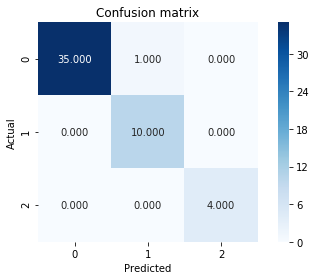

In [183]:
y_pred = classifier.predict(x_test_scaled)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [184]:
accuracy = metrics.accuracy_score(y_test, y_pred)
error = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average = None)
recall = metrics.recall_score(y_test, y_pred, average = None)
F1_score = metrics.f1_score(y_test, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])
print("Average F1 Score", ((0.98591549 + 0.95238095 +1.0)/3))

[0.98, 0.020000000000000018, array([1.        , 0.90909091, 1.        ]), array([0.97222222, 1.        , 1.        ]), array([0.98591549, 0.95238095, 1.        ])]
Average F1 Score 0.9794321466666668


In [185]:
#k-Nearest Neighbors
classifier = KNeighborsClassifier(n_neighbors = 3)  
classifier.fit(x_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

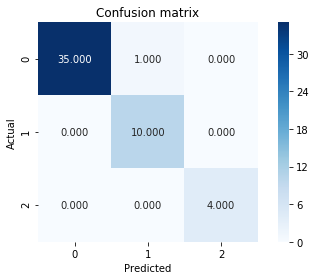

In [186]:
y_pred = classifier.predict(x_test_scaled)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [187]:
accuracy = metrics.accuracy_score(y_test, y_pred)
error = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average = None)
recall = metrics.recall_score(y_test, y_pred, average = None)
F1_score = metrics.f1_score(y_test, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])
print("Average F1 Score", ((0.98591549+ 0.95238095+1)/3))

[0.98, 0.020000000000000018, array([1.        , 0.90909091, 1.        ]), array([0.97222222, 1.        , 1.        ]), array([0.98591549, 0.95238095, 1.        ])]
Average F1 Score 0.9794321466666668


In [188]:
#Naive Bayes classifier
classifier = GaussianNB()  
classifier.fit(x_train_scaled, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

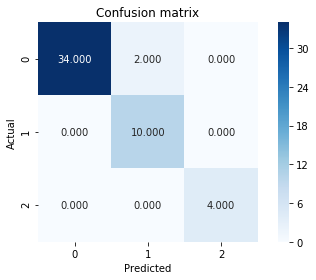

In [189]:
y_pred = classifier.predict(x_test_scaled)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [190]:
accuracy = metrics.accuracy_score(y_test, y_pred)
error = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average = None)
recall = metrics.recall_score(y_test, y_pred, average = None)
F1_score = metrics.f1_score(y_test, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])
print("Average F1 Score: ", (F1_score[0] + F1_score[1] + F1_score[2])/3.0)

[0.96, 0.040000000000000036, array([1.        , 0.83333333, 1.        ]), array([0.94444444, 1.        , 1.        ]), array([0.97142857, 0.90909091, 1.        ])]
Average F1 Score:  0.9601731601731602


In [191]:
#Support Vector Machine Classifier
classifier = SVC(kernel='rbf')  
classifier.fit(x_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

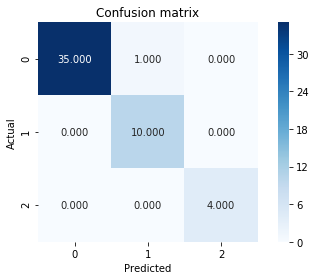

In [192]:
y_pred = classifier.predict(x_test_scaled)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [193]:
accuracy = metrics.accuracy_score(y_test, y_pred)
error = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average = None)
recall = metrics.recall_score(y_test, y_pred, average = None)
F1_score = metrics.f1_score(y_test, y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])
print("Average F1 Score: ", (F1_score[0] + F1_score[1] + F1_score[2])/3.0)

[0.98, 0.020000000000000018, array([1.        , 0.90909091, 1.        ]), array([0.97222222, 1.        , 1.        ]), array([0.98591549, 0.95238095, 1.        ])]
Average F1 Score:  0.9794321484462328


In [83]:
#descision tree
dT = 0.9794321466666668
#k-nearest 
kn = 0.9794321466666668
#svm
svm = 0.9794321484462328
#naive bayes
naiveB= 0.9601731601731602

#SVM is the best classifier
print(svm-dT)

1.779566050075232e-09
